In [2]:
from pyspark.sql import SparkSession
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import pandas as pd
from pathlib import Path
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter



def load_csv(path, table_name):
    df = spark.read.csv(path, header=True)
    
    df.createOrReplaceTempView(table_name)

small_data_path="small_sample"
big_data_path="patient_data"


spark = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .getOrCreate()


# patients_df = spark.read.csv(f"{small_data_path}/patients.csv", header=True)
# patients_df.createOrReplaceTempView("patients_df")
# conditions_df = spark.read.csv(f"{small_data_path}/conditions.csv", header=True)
# conditions_df.createOrReplaceTempView("conditions_df")
# conditions_df[['START']].show()

load_csv(f"{big_data_path}/encounters.csv", "encounters")
load_csv(f"{big_data_path}/patients.csv", "patients")
load_csv(f"{big_data_path}/allergies.csv", "allergies")
load_csv(f"{big_data_path}/organizations.csv", "organizations")
load_csv(f"{big_data_path}/conditions.csv", "conditions")
#load_csv(f"{small_data_path}/devices.csv", "devices")
#load_csv(f"{small_data_path}/patients.csv", "patients")
#load_csv(f"{small_data_path}/allergies.csv", "allergies")
# load_csv(f"{small_data_path}/procedures.csv", "procedures")
# load_csv(f"{small_data_path}/medications.csv", "medications")
# load_csv(f"{small_data_path}/payers.csv", "payers")
# load_csv(f"{small_data_path}/immunizations.csv", "immunizations")
# load_csv(f"{small_data_path}/payer_transitions.csv", "payer_transitions")
# load_csv(f"{small_data_path}/supplies.csv", "supplies")
# load_csv(f"{small_data_path}/careplans.csv", "careplans")
# load_csv(f"{small_data_path}/organizations.csv", "organizations")
# load_csv(f"{small_data_path}/observations.csv", "observations")
# load_csv(f"{small_data_path}/providers.csv", "providers")
# load_csv(f"{small_data_path}/imaging_studies.csv", "imaging_studies")


In [2]:
conditions_df = spark.sql("""
select * from conditions 
""").toPandas()

In [3]:
conditions_df.DESCRIPTION.nunique()

222

In [4]:
enc_con_grouped  = spark.sql("""
select c.description, 
       count(*) num_encounter, 
       avg(TOTAL_CLAIM_COST) avg_cost,
       sum(TOTAL_CLAIM_COST) total_revenue, 
       count(distinct e.patient) uniq_patient_cnt
from encounters e, conditions c
where e.id = c.encounter
group by c.description
""").toPandas()
enc_con_grouped

,description,num_encounter,avg_cost,total_revenue,uniq_patient_cnt
0,Atrial Fibrillation,7827,113.515669,888487.14,7827
1,Viral sinusitis (disorder),59538,69.890000,4161110.82,35233
2,Sepsis caused by Staphylococcus aureus,1,116.480000,116.48,1
3,Pain (finding),47,116.480000,5474.56,47
4,Intellectual disability (disorder),74,116.480000,8619.52,74
...,...,...,...,...,...
217,Chronic low back pain (finding),8399,69.890000,587006.11,8399
218,Spina bifida occulta (disorder),12,116.480000,1397.76,12
219,Non-small cell carcinoma of lung TNM stage 1 ...,2192,69.890000,153198.88,2192
220,Perennial allergic rhinitis,324,69.890000,22644.36,324


## Costs of conditions

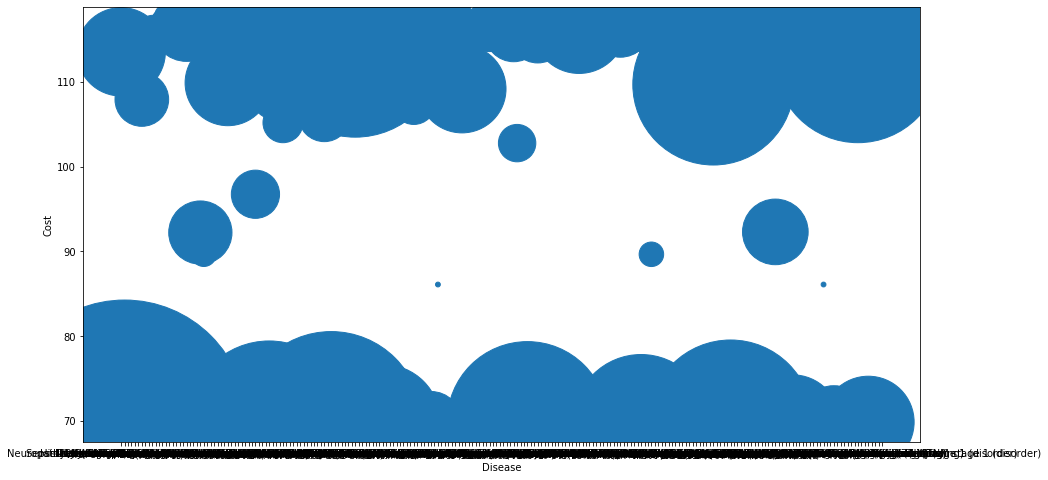

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,8))
plt.scatter(enc_con_grouped["description"], enc_con_grouped["avg_cost"],s = enc_con_grouped["num_encounter"])
plt.xlabel("Disease")
plt.ylabel("Cost")
plt.savefig('sample_4.pdf')
plt.show()
#plt.savefig("figure.png") # save as pdfplt.savefig("figure.pdf") # save as pdf

We can see that costs of most conditions seems to be around 116 and 68.

## Find out what diseases are most prevalent and the costs of these diseases.

<ipython-input-6-fd614700d15f>:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar().set_label("No of Encounters")


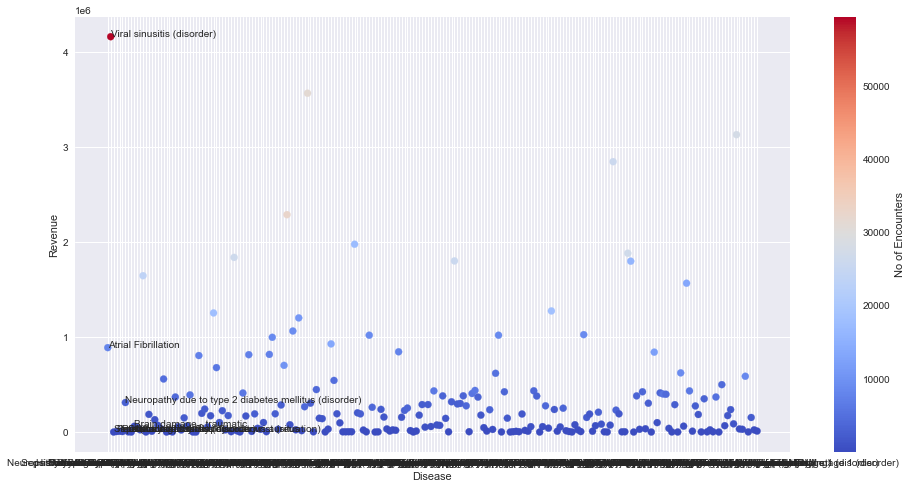

In [6]:
plt.figure(figsize = (16,8))
plt.style.use("seaborn")
plt.scatter(enc_con_grouped["description"],enc_con_grouped["total_revenue"],c = enc_con_grouped["num_encounter"],cmap = "coolwarm")
plt.colorbar().set_label("No of Encounters")
plt.xlabel("Disease")
plt.ylabel("Revenue")
for i in range(10):
    plt.annotate(enc_con_grouped.description.iloc[i],(enc_con_grouped["description"].iloc[i],enc_con_grouped["total_revenue"].iloc[i]))
plt.savefig('sample_5.pdf')
plt.show()

From the above graph viral sinusitis is the condition with the most revenue and most number of encounters. 
Viral sinusitis can be triggered by an allergic reaction. 

## Exploring allergies csv

In [7]:
allergies = pd.read_csv("patient_data/allergies.csv")

In [8]:
def isCured(x):
    if type(x) != str:
        return 0
    else:
        return 1

### Do we have any patients that are cured

In [9]:
allergies["isCured"] = allergies.STOP.apply(isCured)
allergies.head()

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,isCured
0,1957-06-28,NaN,56211549-b840-4b4d-5fc1-84c81b8c299a,1ea98664-dfda-acb3-aa92-416de40ac19e,91934008,Allergy to nut,0
1,1957-06-28,NaN,56211549-b840-4b4d-5fc1-84c81b8c299a,1ea98664-dfda-acb3-aa92-416de40ac19e,91935009,Allergy to peanuts,0
2,1945-11-21,NaN,c93775b6-53ea-e31b-6d86-545b7499d320,dc9723ed-bb1a-10ff-4248-6bc8251bfe8e,418689008,Allergy to grass pollen,0
3,1978-12-25,NaN,35e859ef-8c54-ee22-7fc7-6f16f126bc9b,1210dd60-dace-4a89-3491-61e42f9900f3,232347008,Dander (animal) allergy,0
4,1954-12-07,NaN,15ff216f-e682-5f59-26a8-7209631d95b7,1afd76d2-ab0b-2eec-766f-e63476fa181e,419474003,Allergy to mould,0


In [10]:
allergies.DESCRIPTION.nunique(),allergies.DESCRIPTION.count(),allergies.CODE.nunique(),allergies.CODE.count()


(15, 6189, 15, 6189)

In [11]:
import numpy as np
allergy_group = allergies.groupby(["DESCRIPTION"]).agg({"DESCRIPTION":"count","isCured":"sum"})
allergy_group = allergy_group.rename(columns = {"DESCRIPTION":"COUNT"})
allergy_group = allergy_group.reset_index().sort_values(by = ["COUNT"],ascending = False)
allergy_group["isNotCured"] = allergy_group["COUNT"] - allergy_group["isCured"]
#allergy_group["RecoveryRate"] = np.round(100*allergy_group["isCured"]/allergy_group["COUNT"],0)
allergy_group

,DESCRIPTION,COUNT,isCured,isNotCured
14,Shellfish allergy,1170,0,1170
5,Allergy to mould,959,41,918
11,Dander (animal) allergy,730,25,705
7,Allergy to peanuts,525,0,525
9,Allergy to tree pollen,430,7,423
4,Allergy to grass pollen,414,8,406
12,House dust mite allergy,403,7,396
3,Allergy to fish,398,0,398
6,Allergy to nut,383,0,383
0,Allergy to bee venom,264,0,264


In [12]:
df_allg = spark.sql("""
select *,
      case when STOP is null then 0 else  1  end cured
from allergies 
""").toPandas()
df_allg

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,cured
0,1957-06-28,None,56211549-b840-4b4d-5fc1-84c81b8c299a,1ea98664-dfda-acb3-aa92-416de40ac19e,91934008,Allergy to nut,0
1,1957-06-28,None,56211549-b840-4b4d-5fc1-84c81b8c299a,1ea98664-dfda-acb3-aa92-416de40ac19e,91935009,Allergy to peanuts,0
2,1945-11-21,None,c93775b6-53ea-e31b-6d86-545b7499d320,dc9723ed-bb1a-10ff-4248-6bc8251bfe8e,418689008,Allergy to grass pollen,0
3,1978-12-25,None,35e859ef-8c54-ee22-7fc7-6f16f126bc9b,1210dd60-dace-4a89-3491-61e42f9900f3,232347008,Dander (animal) allergy,0
4,1954-12-07,None,15ff216f-e682-5f59-26a8-7209631d95b7,1afd76d2-ab0b-2eec-766f-e63476fa181e,419474003,Allergy to mould,0
...,...,...,...,...,...,...,...
6184,1960-06-12,None,419658a0-379d-f84c-1270-738e4a01448b,32392a0a-57a7-3599-c36e-8f0e1ddf31ed,232347008,Dander (animal) allergy,0
6185,1960-06-12,None,419658a0-379d-f84c-1270-738e4a01448b,32392a0a-57a7-3599-c36e-8f0e1ddf31ed,91930004,Allergy to eggs,0
6186,1960-06-12,None,419658a0-379d-f84c-1270-738e4a01448b,32392a0a-57a7-3599-c36e-8f0e1ddf31ed,300913006,Shellfish allergy,0
6187,1960-06-12,None,419658a0-379d-f84c-1270-738e4a01448b,32392a0a-57a7-3599-c36e-8f0e1ddf31ed,91934008,Allergy to nut,0


In [13]:
#Lets see how many distinct kind of allergies exists
allegies_pdf = spark.sql("""
select DESCRIPTION, count(*) cnt
from allergies 
group by DESCRIPTION
order by 2 desc
""").toPandas()

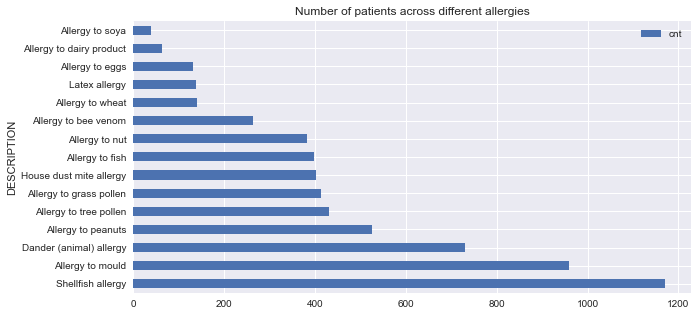

In [14]:
#Lets see which are the most common ones and which are the least common ones
%matplotlib inline
import matplotlib.pyplot as plt

allegies_pdf.plot(kind = 'barh', rot = 0, figsize=(10,5), x="DESCRIPTION", y="cnt",title="Number of patients across different allergies")
plt.show
plt.savefig("figure_3.pdf") # save as pdf

In [15]:
#Lets see cured patients and how much time it takes to cure different allergies
allergies_cured_pdf = spark.sql("""
select DESCRIPTION, 
       count(*) total,
       sum(cured) is_cured,
       count(*)-sum(cured) not_cured,
       round(sum(cured)/count(*),1) recovery_rate
from 
(select *,
      case when STOP is null then 0 else  1  end cured
      from allergies
      )
group by DESCRIPTION
""").toPandas()
allergies_cured_pdf

,DESCRIPTION,total,is_cured,not_cured,recovery_rate
0,Allergy to peanuts,525,0,525,0.0
1,Latex allergy,139,0,139,0.0
2,Allergy to soya,39,0,39,0.0
3,Shellfish allergy,1170,0,1170,0.0
4,Allergy to wheat,140,2,138,0.0
5,Allergy to fish,398,0,398,0.0
6,Allergy to dairy product,63,0,63,0.0
7,Allergy to bee venom,264,0,264,0.0
8,Dander (animal) allergy,730,25,705,0.0
9,Allergy to tree pollen,430,7,423,0.0


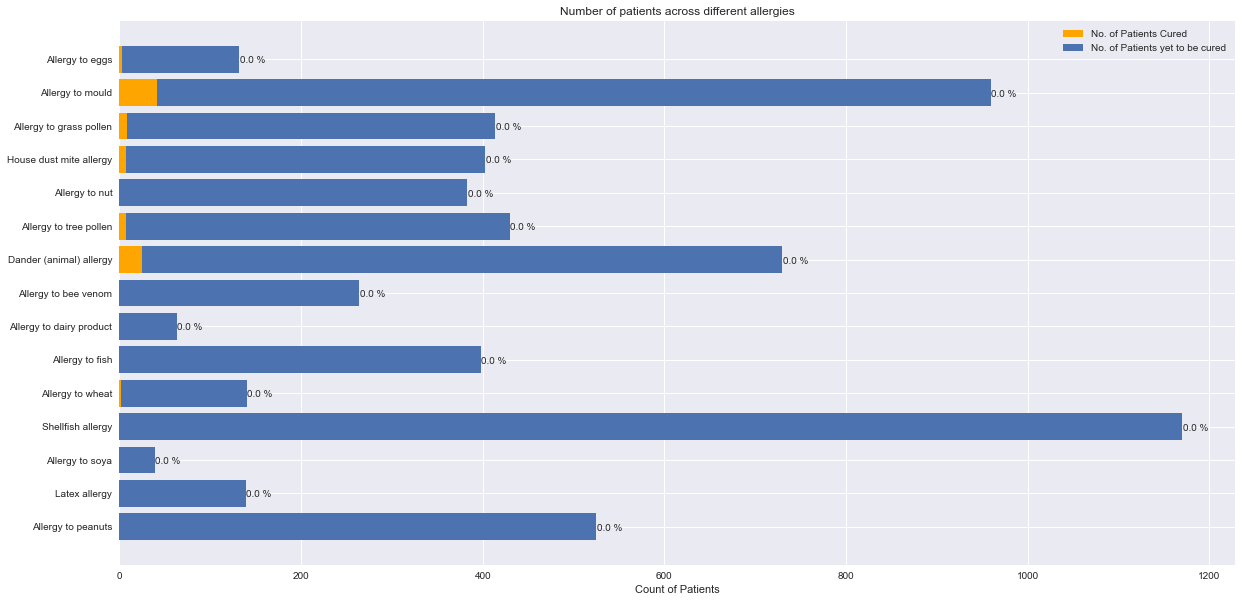

In [33]:

plt.figure(figsize = (20,10))
plt.barh(allergies_cured_pdf.DESCRIPTION,allergies_cured_pdf.is_cured,color = "orange")
plt.barh(allergies_cured_pdf.DESCRIPTION,allergies_cured_pdf.not_cured,left = allergies_cured_pdf.is_cured)
plt.legend(["No. of Patients Cured","No. of Patients yet to be cured"])
plt.title("Number of patients across different allergies")
plt.xlabel("Count of Patients")
for i in range(len(allergies_cured_pdf.DESCRIPTION)):
    plt.annotate(str(allergies_cured_pdf.recovery_rate.iloc[i])+" %",(allergies_cured_pdf.total.iloc[i]+0.5,i-0.12))
plt.savefig('sample_7.pdf')
plt.show()

From the above graph its clear that Allergy to Mould, Dander and shellfish allergy are the most common ones. Whereas soya and dairy allergies are the least common ones. 
Also allergies to peanuts,fish,nut,latex, bee venom, soya, dairy, and Shellfish seems to have no treatment as there hasn't been a single patient recovered from these. 

In [274]:
#From encounter, get distinct encounterclass, description, code,providers
#Group encounterclass by revenue and get the group with the highest revenue (base_encounter)
#Group description by revenue and get the group with the highest revenue (base_encounter)

In [275]:
#Merge encounter and patient
#Group encounterclass by healthcare expense from patient table - Healthcare_Expenses
#Get the highest encounter by healthcare expense by age group

In [276]:
#From procedure, get unique description
#Join procedure and encounter on encounter_id
#Get unique procedure after the merge
#Group description, aggregate total cost, and count encounter (Two tables to show the revenue generated as well as count of encounter across 
#1) different purpose of visits,2) different procedures)   

In [17]:
#number of allergies in conditions
spark.sql(""" 
select count(*) from allergies 
where code in (select code from conditions)
""").toPandas()

,count(1)
0,139


In [18]:
#allergies in conditions
spark.sql(""" 
select * from allergies 
where code in (select code from conditions)
""").toPandas()

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,1956-06-27,None,4025fce8-074c-2a9c-6a7e-eeaca63ec657,f53dd6ac-7cba-a57f-1ef0-d57f44902fe0,300916003,Latex allergy
1,1958-01-25,None,3ffe6140-45a3-3686-1b62-80938571573b,ff416bcd-e061-1d94-5c62-879bcd445696,300916003,Latex allergy
2,1922-04-25,None,e0a4fc42-4058-f6c4-8d19-16c814dfaa0c,fb722454-4a60-f751-743b-75a53977e6f5,300916003,Latex allergy
3,1930-08-17,None,1ce5781e-b140-060c-519e-7b23336328bd,f18b60b9-0cf3-4670-282b-d00988caee1c,300916003,Latex allergy
4,1969-01-31,None,9825b033-f092-3cfb-3fd2-802ebd87e1c7,35794c30-a880-4cdf-b533-3a4a322d396e,300916003,Latex allergy
...,...,...,...,...,...,...
134,1950-11-11,None,e56d2f88-bfb4-fc98-641b-fc19129a2323,22214a19-9551-ef6b-c969-183079d09e1b,300916003,Latex allergy
135,1968-05-05,None,7d3ef937-b00f-a085-db99-faac888e6401,e8878986-16ba-d920-9823-5d1e5ced2290,300916003,Latex allergy
136,1947-03-03,None,b24a5509-898b-ae77-7c8e-6cb295ad3f2e,0ee14fef-fb12-aaa9-57cf-3f0a3d157d76,300916003,Latex allergy
137,1952-05-16,None,d71d915f-2606-0966-2e07-609dbc17ebdb,ae3d18fc-0978-bcb0-16bf-86db90a6722e,300916003,Latex allergy


From the above table, we see that it is only latex allergy that is recorded in conditions csv.
The total count of latex allergy is 139 and it is same count in allergy table.
We agree that all latex allergies are found in allergies csv, so we use the allergy csv for analysis.

From the table above, we see that cost is uniform across all allergies.

### Allergy distribution by gender

In [19]:
gender_df = spark.sql(""" 
select a.description,p.gender, 
       count(*) cnt
  from allergies a, patients p, encounters e
 where a.patient = p.ID
   and a.encounter = e.ID
   group by a.description,
            p.gender 
order by 3 desc, 1
""").toPandas()
gender_df

,description,gender,cnt
0,Shellfish allergy,M,661
1,Allergy to mould,M,521
2,Shellfish allergy,F,509
3,Allergy to mould,F,438
4,Dander (animal) allergy,M,390
5,Dander (animal) allergy,F,340
6,Allergy to peanuts,F,264
7,Allergy to peanuts,M,261
8,Allergy to tree pollen,M,224
9,Allergy to grass pollen,M,216


In [284]:
#a = gender_df.pivot_table(index = 'gender', values = 'description',columns = 'description', aggfunc = 'sum')
#a

description,Allergy to bee venom,Allergy to dairy product,Allergy to eggs,Allergy to fish,Allergy to grass pollen,Allergy to mould,Allergy to nut,Allergy to peanuts,Allergy to soya,Allergy to tree pollen,Allergy to wheat,Dander (animal) allergy,House dust mite allergy,Latex allergy,Shellfish allergy
gender,,,,,,,,,,,,,,,
F,132,36,64,186,198,438,180,264,17,206,67,340,206,70,509
M,132,27,68,212,216,521,203,261,22,224,73,390,197,69,661


In [285]:
#gender_df_transposed = a.T # or df1.transpose()
#gender_df_transposed

gender,F,M
description,,
Allergy to bee venom,132,132
Allergy to dairy product,36,27
Allergy to eggs,64,68
Allergy to fish,186,212
Allergy to grass pollen,198,216
Allergy to mould,438,521
Allergy to nut,180,203
Allergy to peanuts,264,261
Allergy to soya,17,22


In [20]:
gender_df = spark.sql(""" 
select a.description,p.gender,  count(*) cnt
  from allergies a, patients p, encounters e
 where a.patient = p.ID
   and a.encounter = e.ID
   group by a.description,
            p.gender 
order by 3 desc, 1
""")


In [21]:
gender_df_pvt = gender_df.groupBy('description') \
         .pivot("gender") \
         .sum('cnt').toPandas()
gender_df_pvt

,description,F,M
0,Allergy to peanuts,264,261
1,Latex allergy,70,69
2,Allergy to soya,17,22
3,Shellfish allergy,509,661
4,Allergy to wheat,67,73
5,Allergy to fish,186,212
6,Allergy to dairy product,36,27
7,Allergy to bee venom,132,132
8,Dander (animal) allergy,340,390
9,Allergy to tree pollen,206,224


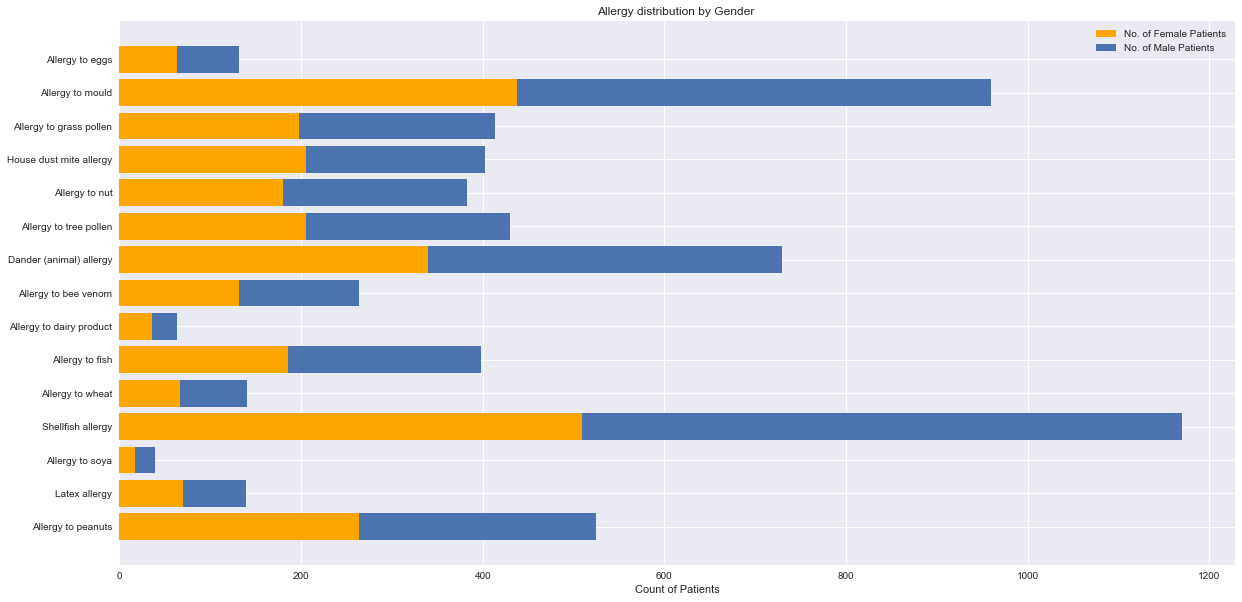

In [22]:
plt.figure(figsize = (20,10))
plt.barh(gender_df_pvt.description,gender_df_pvt.F,color = "orange")
plt.barh(gender_df_pvt.description,gender_df_pvt.M,left = gender_df_pvt.F)
plt.legend(["No. of Female Patients","No. of Male Patients"])
plt.title("Allergy distribution by Gender ")
plt.xlabel("Count of Patients")

plt.show()

## Allergy distribution by Race

In [23]:
allergy_by_race = spark.sql(""" 
select a.description,p.race, count(*) cnt
  from allergies a, patients p, encounters e
 where a.patient = p.ID
   and a.encounter = e.ID
   group by a.description,p.race
order by 3 desc, 1
""")

In [24]:
allergy_by_race_pvt = allergy_by_race.groupBy('description') \
         .pivot("race") \
         .sum('cnt').toPandas()
allergy_by_race_pvt.set_index('description', inplace=True)

In [25]:
allergy_by_race_pvt 

,asian,black,native,other,white
description,,,,,
Allergy to peanuts,31.0,182,2.0,1.0,309
Latex allergy,11.0,56,NaN,NaN,72
Allergy to soya,NaN,14,NaN,NaN,25
Shellfish allergy,71.0,386,12.0,5.0,696
Allergy to wheat,10.0,48,2.0,NaN,80
Allergy to fish,29.0,151,1.0,NaN,217
Allergy to dairy product,4.0,24,NaN,NaN,35
Allergy to bee venom,18.0,84,2.0,1.0,159
Dander (animal) allergy,57.0,253,6.0,1.0,413


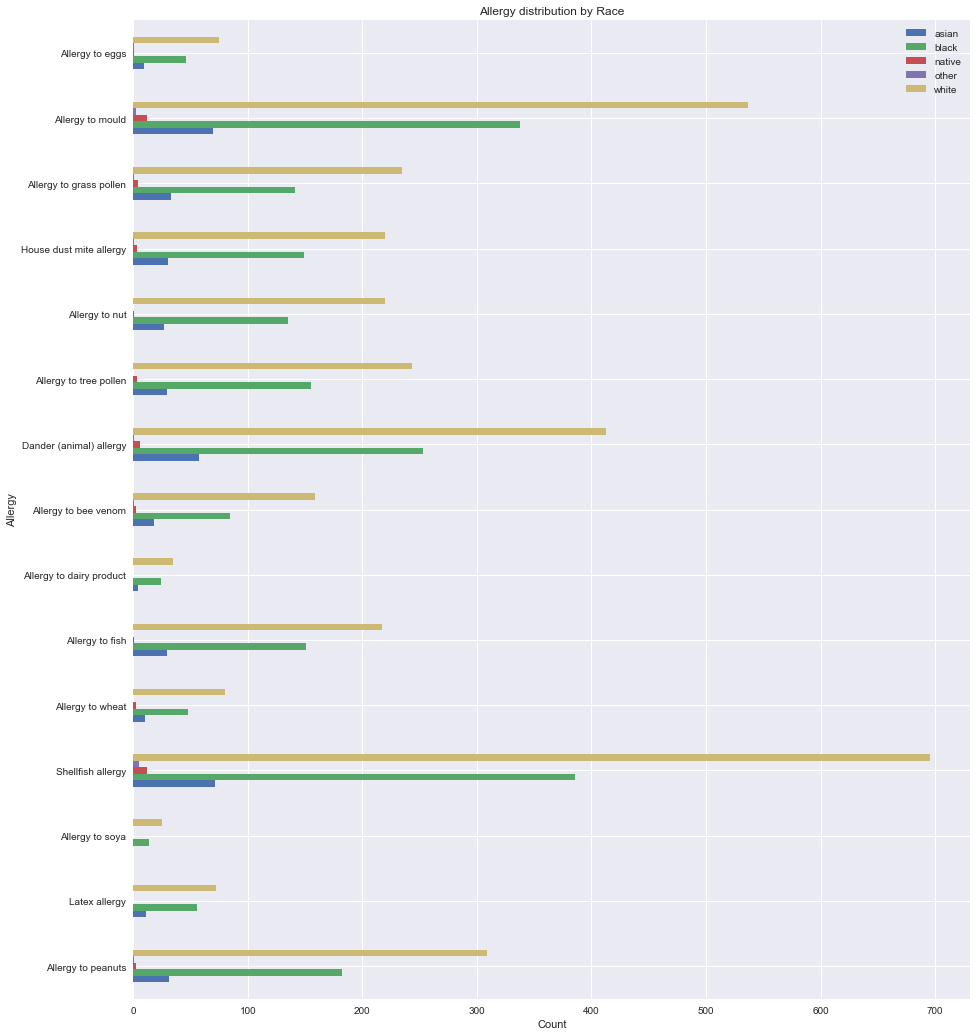

In [28]:
allergy_by_race_pvt.plot.barh(figsize=(15, 18))
plt.ylabel('Allergy')
plt.xlabel('Count')
plt.title("Allergy distribution by Race")
plt.show()

## Allergy distribution by cost and city

In [29]:
#check if allergy encounter costs vary by description or city
spark.sql(""" 
select a.description, p.city, e.total_claim_cost
  from allergies a, patients p, encounters e
 where a.patient = p.ID
   and a.encounter = e.ID
order by 3 desc
""").toPandas()

,description,city,total_claim_cost
0,Shellfish allergy,Aberdeen,69.89
1,Dander (animal) allergy,Baltimore,69.89
2,Allergy to tree pollen,Baltimore,69.89
3,Shellfish allergy,Baltimore,69.89
4,Dander (animal) allergy,Aspen Hill,69.89
...,...,...,...
6184,Shellfish allergy,Baltimore,69.89
6185,Shellfish allergy,Germantown,69.89
6186,Dander (animal) allergy,Germantown,69.89
6187,Shellfish allergy,Germantown,69.89


We see that for each allergy encounter, cost is same despite the location.

In [30]:
#check if some patients pay more than others for allergy encounters
spark.sql(""" 
select p.city, count(*) as total_allergies, sum(e.total_claim_cost) as cost, sum(e.total_claim_cost)/count(*) cost_per_patient
  from allergies a, patients p, encounters e
 where a.patient = p.ID
   and a.encounter = e.ID
group by p.city
order by 3 desc
""").toPandas()

,city,total_allergies,cost,cost_per_patient
0,Baltimore,872,60944.08,69.89
1,Columbia,120,8386.80,69.89
2,Gaithersburg,111,7757.79,69.89
3,Germantown,107,7478.23,69.89
4,Glen Burnie,92,6429.88,69.89
...,...,...,...,...
317,Hurlock,1,69.89,69.89
318,Perryville,1,69.89,69.89
319,Cottage City,1,69.89,69.89
320,Sabillasville,1,69.89,69.89


We see that everyone pays same amount for allergy encounter.

In [31]:
#no of allergies per area (city) and cost to determine areas with high allergies and determine things to help with environment
allergy_by_city = spark.sql(""" 
select p.city, count(*) as total_allergies, sum(total_claim_cost) as cost,o.lat, o.lon
  from allergies a, patients p, encounters e, organizations o
 where a.patient = p.ID
   and a.encounter = e.ID
   and e.organization = o.ID
group by p.city, o.lat, o.lon
order by 3 desc
""").toPandas()
allergy_by_city

,city,total_allergies,cost,lat,lon
0,Baltimore,526,36762.14,39.300213,-76.610516
1,Baltimore,204,14257.56,39.392422,-76.621509
2,Columbia,118,8247.02,39.201146,-76.85905
3,Germantown,107,7478.23,39.17422,-77.263703
4,Glen Burnie,92,6429.88,39.156271,-76.606996
...,...,...,...,...,...
544,Brentwood,1,69.89,38.925931,-76.913468
545,Bowleys Quarters,1,69.89,39.27272,-76.5025
546,Baltimore,1,69.89,39.40007,-76.60994
547,Lanham,1,69.89,38.925931,-76.913468


#### Export csv so I can create a map on powerbi

In [10]:
#import pandas as pd
#df = allergy_by_city
#allergy_by_city.to_csv("allergy_by_city.csv", sep = ',', index = False)


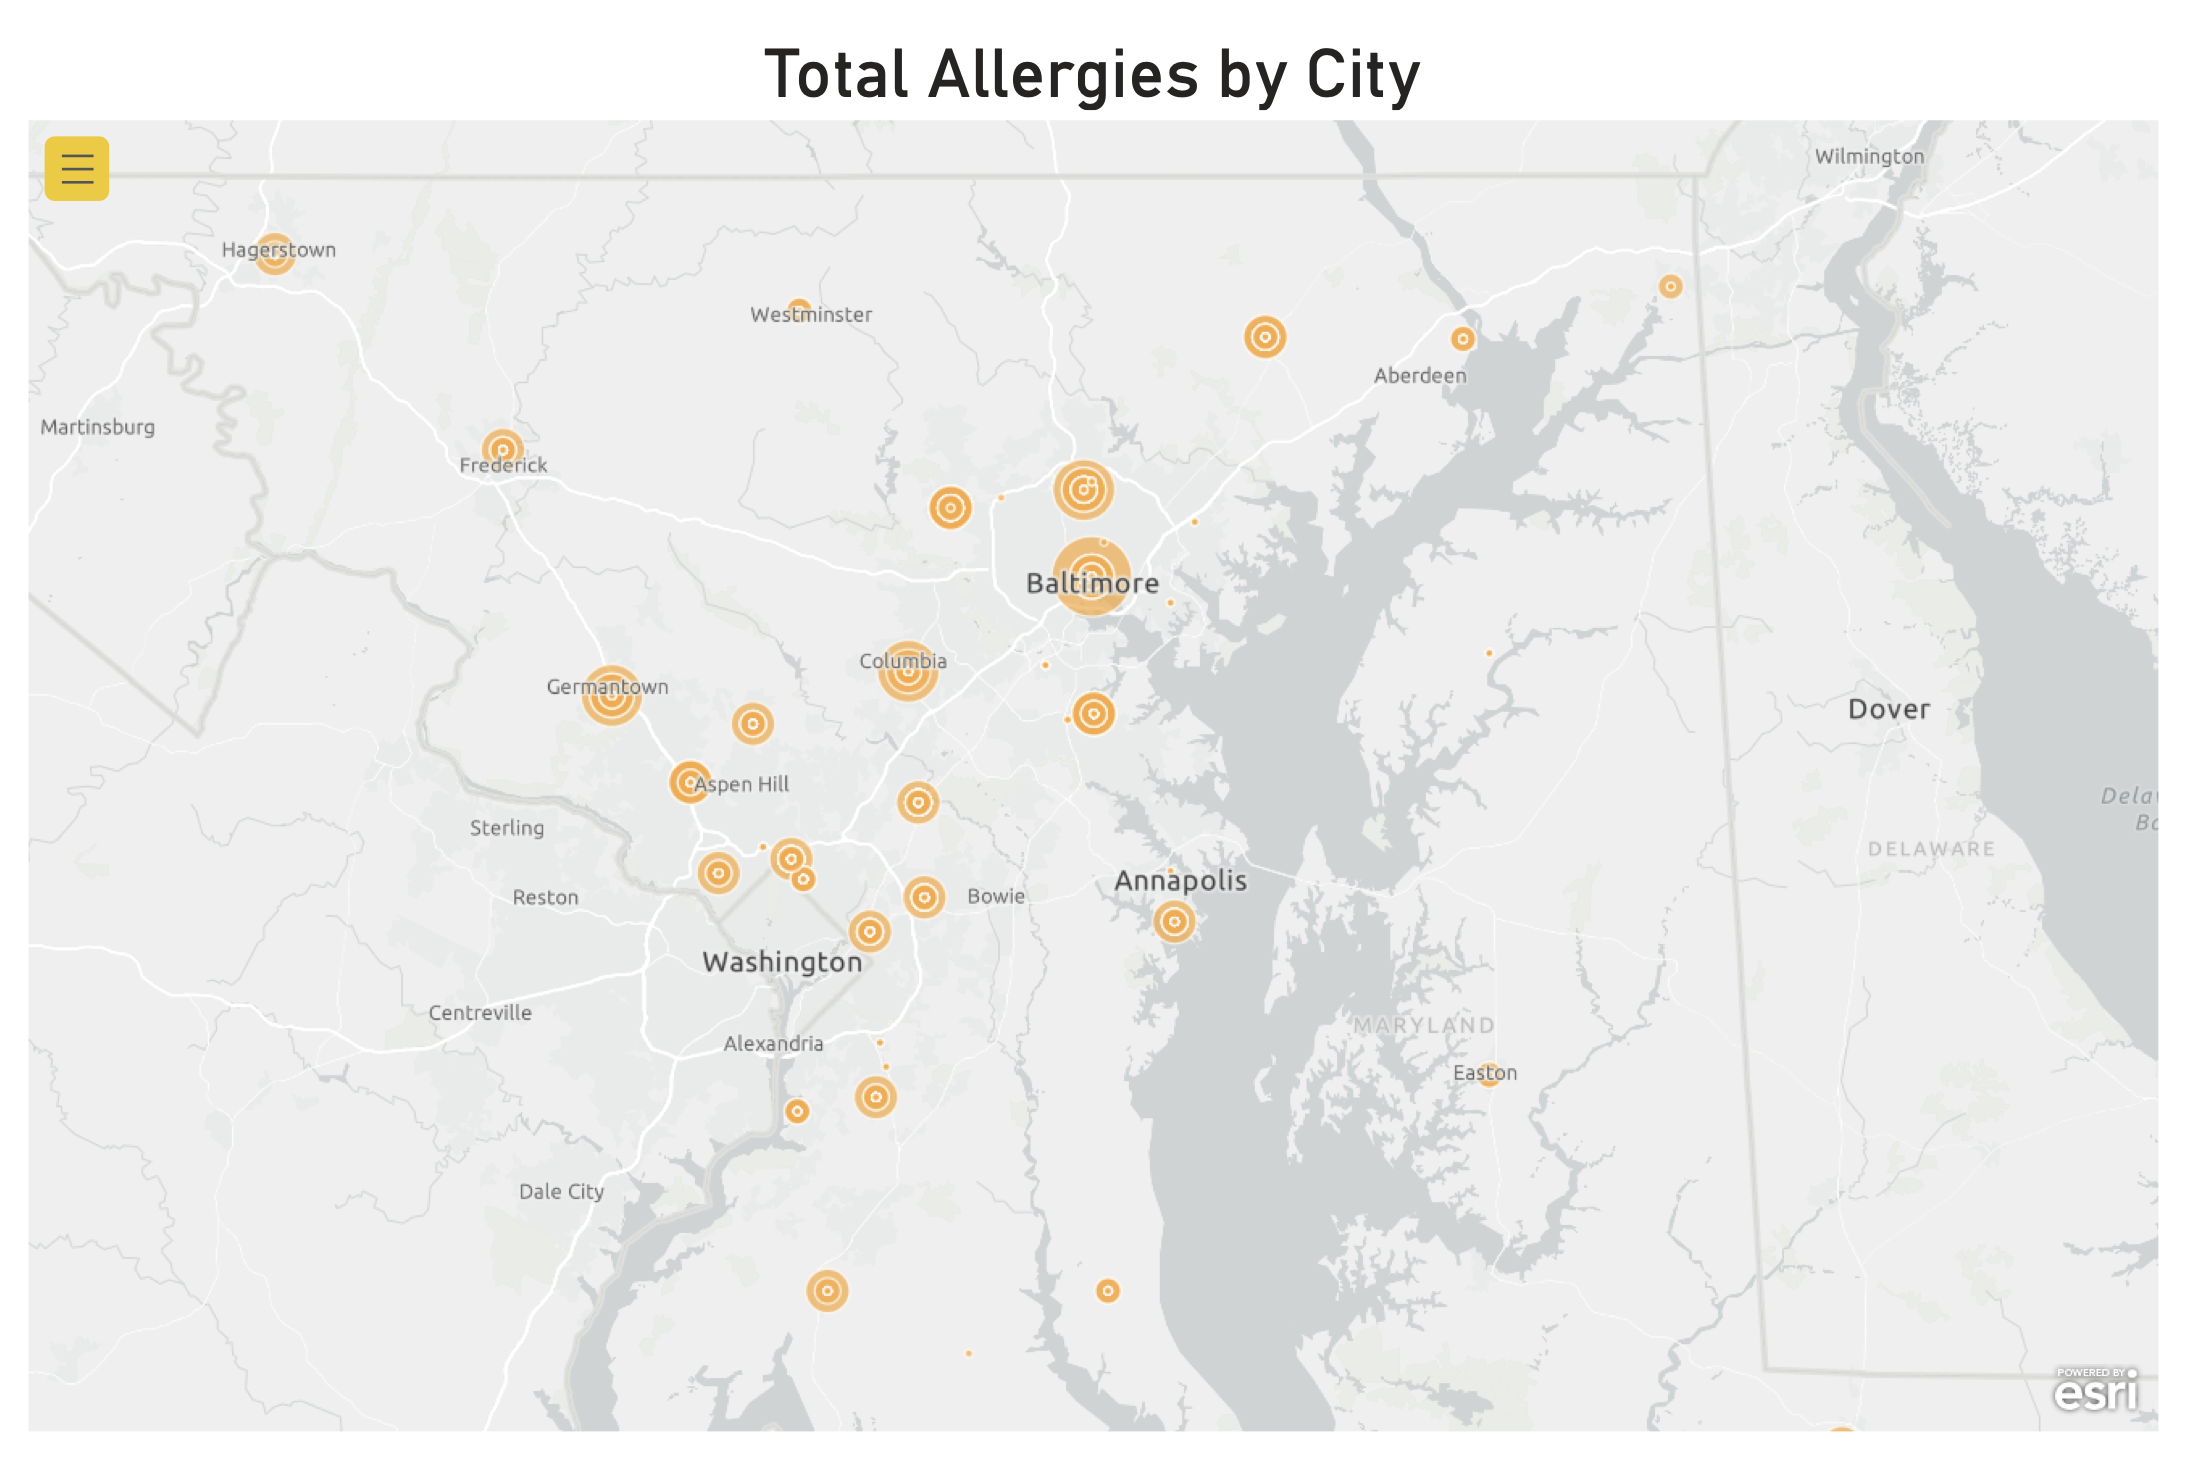

In [8]:

from IPython.display import Image
Image(filename='map_of_cities.png')



Total allergies per city using organizations' lat and lon.

In [5]:
def get_geocode(query):
    print(f"querying {query}")
    rtn = geolocator.geocode("%s, Maryland US" % query)
    print(rtn)
    return rtn


cities_gps_csv_path = Path("maryland_cities_gps.csv")
if cities_gps_csv_path.exists():
    cities_gps = pd.read_csv("maryland_cities_gps.csv")
else:
    cities_gps = spark.sql(""" select  distinct city from  patients""").toPandas()
    geolocator = Nominatim(user_agent="MD Analysis")
    #because Nominatim is rate limited, to not get blocked we have to send a request every second
    geocode = RateLimiter(get_geocode, min_delay_seconds=1)
    cities_gps['location'] = cities_gps['city'].apply(geocode)
    cities_gps['latitude'] = cities_gps['location'].apply(lambda x: x.latitude)
    cities_gps['longitude'] = cities_gps['location'].apply(lambda x: x.longitude)
    cities_gps['county'] = cities_gps['location'].apply(lambda x: x.county)
    cities_gps.to_csv("maryland_cities_gps.csv")
 
allergies_per_city = spark.sql(""" 
select p.city, p.county, count(*) as total_allergies, sum(total_claim_cost) as cost
  from allergies a, patients p, encounters e
 where a.patient = p.ID
   and a.encounter = e.ID
group by p.county, p.city
order by 3 desc
""").toPandas()
allergies_per_city['county'] = allergies_per_city['county'].apply(lambda r: " ".join(r.split()[0:-1]))
allergies_per_city_gps = allergies_per_city.merge(cities_gps, left_on='city', right_on='city')
allergies_per_city_gps


,city,county,total_allergies,cost,Unnamed: 0,location,latitude,longitude
0,Baltimore,Baltimore,872,60944.08,157,"Baltimore, Maryland, 21202-4036, United States",39.290882,-76.610759
1,Columbia,Howard,120,8386.80,160,"Columbia, Howard County, Maryland, United States",39.193843,-76.864609
2,Gaithersburg,Montgomery,111,7757.79,109,"Gaithersburg, Montgomery County, Maryland, Uni...",39.139919,-77.192921
3,Germantown,Montgomery,107,7478.23,64,"Germantown, Montgomery County, Maryland, Unite...",39.171172,-77.265599
4,Glen Burnie,Anne Arundel,92,6429.88,57,"Glen Burnie, Anne Arundel County, Maryland, Un...",39.159544,-76.615151
...,...,...,...,...,...,...,...,...
163,Fruitland,Wicomico,1,69.89,84,"Fruitland, Wicomico County, Maryland, 21826, U...",38.322063,-75.620203
164,Braddock Heights,Frederick,1,69.89,68,"Braddock Heights, Frederick County, Maryland, ...",39.416908,-77.493161
165,Eden,Somerset,1,69.89,74,"Eden, Somerset County, Maryland, 21822, United...",38.280676,-75.651037
166,Solomons,Calvert,1,69.89,80,"Solomons, Calvert County, Maryland, 20688, Uni...",38.318227,-76.455532


In [7]:
# import the library and its Marker clusterization service
import folium
from folium.plugins import MarkerCluster
# Create a map object and center it to the avarage coordinates to m
m = folium.Map(location=allergies_per_city_gps[["latitude", "longitude"]].mean().to_list(), zoom_start=12, tiles="Stamen Toner")
# if the points are too close to each other, cluster them, create a cluster overlay with MarkerCluster, add to m
marker_cluster = MarkerCluster().add_to(m)
# draw the markers and assign popup and hover texts
# add the markers the the cluster layers so that they are automatically clustered
for i,r in allergies_per_city_gps.iterrows():
    location = (r["latitude"], r["longitude"])
    folium.Marker(location=location,
                      popup = r['city'],
                      tooltip=r['total_allergies'])\
    .add_to(marker_cluster)
# display the map


Allergies by city using patients' lat and lon.

#### Total cost for allergic conditions and encounters

In [32]:
allergy_by_city.agg({"cost":"sum"})

cost    432549.21
dtype: float64